<a href="https://colab.research.google.com/github/John1495/RNA-3D/blob/main/mODEL_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 !pip install biopython viennarna torch-geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 107.1 MB/s eta 0:00:00


In [ ]:
!pip install torch-geometric
!pip install torch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd

# Load CSVs
df_sequences = pd.read_csv("/kaggle/cleaned_train_sequences2.csv")
df_labels = pd.read_csv("/kaggle/train_labels1.csv")

# Extract 'target_id' from label 'ID' column
df_labels['target_id'] = df_labels['ID'].apply(lambda x: "_".join(x.split("_")[:2]))

# Merge on 'target_id'
df_merged = df_labels.merge(df_sequences, on='target_id', how='left')

# Pick a sample target_id to inspect (e.g., first one)
sample_id = df_merged['target_id'].unique()[0]

# Extract data for that sample
df_sample = df_merged[df_merged['target_id'] == sample_id].copy()

# Sort by residue ID for clarity
df_sample.sort_values(by='resid', inplace=True)

# Display result
print(f"Sample RNA ID: {sample_id}")
print(df_sample[['resid', 'resname', 'x_1', 'y_1', 'z_1']])


Sample RNA ID: 17RA_A
    resid resname        x_1        y_1     z_1
0       1       G  35.856998 -10.769000  -7.548
11      2       G  30.230000 -12.075000  -8.614
14      3       C  23.968000 -11.356000  -7.690
15      4       G  19.296000  -9.874000  -4.778
16      5       U  16.362000  -6.047000  -0.706
17      6       A  15.636000  -1.549000   2.463
18      7       A  16.969999   2.893000   4.626
19      8       G  20.391001   6.862000   5.549
20      9       G  24.370001   9.630000   3.348
1      10       A  26.341999  12.365000  -0.594
2      11       U  23.917999  16.023001  -5.418
3      12       U  24.938000  15.565000 -11.243
4      13       A  25.587999  10.095000 -10.004
5      14       C  28.333000   7.804000  -6.255
6      15       C  28.948999   4.836000  -0.756
7      16       U  26.749001   1.390000   3.287
8      17       A  24.118999  -2.821000   6.026
9      18       U  22.771000  -7.665000   5.355
10     19       G  22.330000 -13.626000   3.107
12     20       C 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool

class RNAGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=3):
        super(RNAGNN, self).__init__()

        # GNN layers
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GATConv(hidden_dim, hidden_dim, heads=4, concat=False)

        # MLP for coordinate prediction
        self.lin1 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, output_dim)  # 3D coordinates output

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        # Graph convolutions
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)

        # Predict coordinates
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)

        return x  # Shape: [num_nodes, 3] for x, y, z coordinates


Train: 506, Validation: 169, Test: 169


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Train Loss: 22047.1100, Val Loss: 26550.0095, Val TM-score: 0.0000, Best TM-score: 0.0000
Epoch: 1, Train Loss: 21822.4514, Val Loss: 26487.6086, Val TM-score: 0.0000, Best TM-score: 0.0000
Epoch: 2, Train Loss: 22595.0955, Val Loss: 26130.4073, Val TM-score: 0.0000, Best TM-score: 0.0000
Epoch: 3, Train Loss: 21822.5457, Val Loss: 25576.9322, Val TM-score: 0.0000, Best TM-score: 0.0000
Epoch: 4, Train Loss: 15321.8088, Val Loss: 31504.5507, Val TM-score: 0.0000, Best TM-score: 0.0000
Epoch: 5, Train Loss: 12989.2340, Val Loss: 30469.2388, Val TM-score: 0.0000, Best TM-score: 0.0000
Epoch: 6, Train Loss: 13686.2597, Val Loss: 29668.3485, Val TM-score: 0.0000, Best TM-score: 0.0000
Epoch: 7, Train Loss: 13185.6373, Val Loss: 28463.9106, Val TM-score: 0.0000, Best TM-score: 0.0000
Epoch: 8, Train Loss: 12627.0790, Val Loss: 27639.5229, Val TM-score: 0.0000, Best TM-score: 0.0000
Epoch: 9, Train Loss: 13161.9011, Val Loss: 29059.1723, Val TM-score: 0.0000, Best TM-score: 0.0000


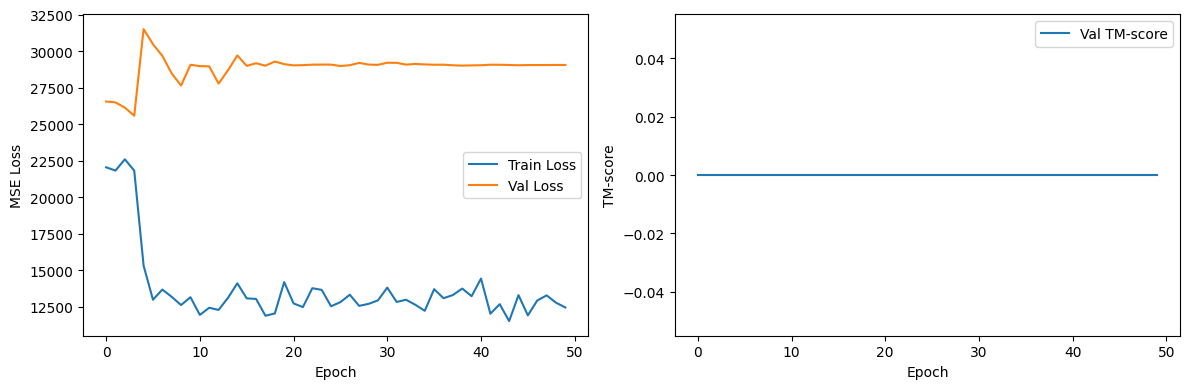

In [ ]:
from sklearn.model_selection import train_test_split
import torch.optim as optim
import numpy as np
import subprocess
import os
import tempfile

# Split data into train/validation/test
train_graphs, test_graphs = train_test_split(rna_graphs, test_size=0.2, random_state=42)
train_graphs, val_graphs = train_test_split(train_graphs, test_size=0.25, random_state=42)

print(f"Train: {len(train_graphs)}, Validation: {len(val_graphs)}, Test: {len(test_graphs)}")

# Create dataloaders
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=32, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

# Calculate TM-score
def calculate_tm_score(pred_coords, true_coords, tmp_dir="/tmp"):
    """
    Calculate TM-score between predicted and true coordinates
    Requires TM-score software (https://zhanggroup.org/TM-score/)
    """
    # Create temp files for predicted and true coordinates
    pred_file = os.path.join(tmp_dir, f"pred_{np.random.randint(10000)}.pdb")
    true_file = os.path.join(tmp_dir, f"true_{np.random.randint(10000)}.pdb")

    # Write coordinates to PDB format
    write_coords_to_pdb(pred_coords, pred_file)
    write_coords_to_pdb(true_coords, true_file)

    # Call TM-score binary
    cmd = f"TMscore {pred_file} {true_file}"
    try:
        result = subprocess.check_output(cmd, shell=True, stderr=subprocess.STDOUT).decode('utf-8')

        # Parse output for TM-score
        for line in result.split('\n'):
            if "TM-score" in line and "=" in line:
                tm_score = float(line.split('=')[1].strip().split()[0])
                return tm_score
    except:
        return 0.0
    finally:
        # Clean up temp files
        if os.path.exists(pred_file):
            os.remove(pred_file)
        if os.path.exists(true_file):
            os.remove(true_file)

    return 0.0

# Helper function to write coordinates to PDB format
def write_coords_to_pdb(coords, filename):
    with open(filename, 'w') as f:
        for i, (x, y, z) in enumerate(coords):
            f.write(f"ATOM  {i+1:5d}  C   UNK A{i+1:4d}    {x:8.3f}{y:8.3f}{z:8.3f}  1.00  0.00           C\n")
        f.write("END\n")

# Training function with TM-score validation
def train_model(model, train_loader, val_loader, num_epochs=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    best_val_loss = float('inf')
    best_tm_score = 0.0

    train_losses = []
    val_losses = []
    val_tm_scores = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = F.mse_loss(out, data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.num_graphs

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        batch_tm_scores = []

        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                out = model(data)
                loss = F.mse_loss(out, data.y)
                val_loss += loss.item() * data.num_graphs

                # Calculate TM-score for a subset of validation examples
                if len(batch_tm_scores) < 10:  # Limit TM-score calculation to save time
                    pred_coords = out.detach().cpu().numpy()
                    true_coords = data.y.detach().cpu().numpy()
                    tm_score = calculate_tm_score(pred_coords, true_coords)
                    batch_tm_scores.append(tm_score)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Average TM-score for this epoch
        avg_tm_score = np.mean(batch_tm_scores) if batch_tm_scores else 0.0
        val_tm_scores.append(avg_tm_score)

        # Update learning rate
        scheduler.step(val_loss)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_rna_gnn_model.pth')

        if avg_tm_score > best_tm_score:
            best_tm_score = avg_tm_score
            torch.save(model.state_dict(), 'best_rna_gnn_model_tm.pth')

        print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val TM-score: {avg_tm_score:.4f}, '
              f'Best TM-score: {best_tm_score:.4f}')

    # Plot training progress
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_tm_scores, label='Val TM-score')
    plt.xlabel('Epoch')
    plt.ylabel('TM-score')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_progress.png')
    plt.show()

    return train_losses, val_losses, val_tm_scores

# Initialize and train the model
input_dim = rna_graphs[0].x.shape[1]  # Number of features
model = RNAGNN(input_dim=input_dim)
train_losses, val_losses, val_tm_scores = train_model(model, train_loader, val_loader, num_epochs=50)


Test Loss: 17533.6536, Test TM-score: 0.0000


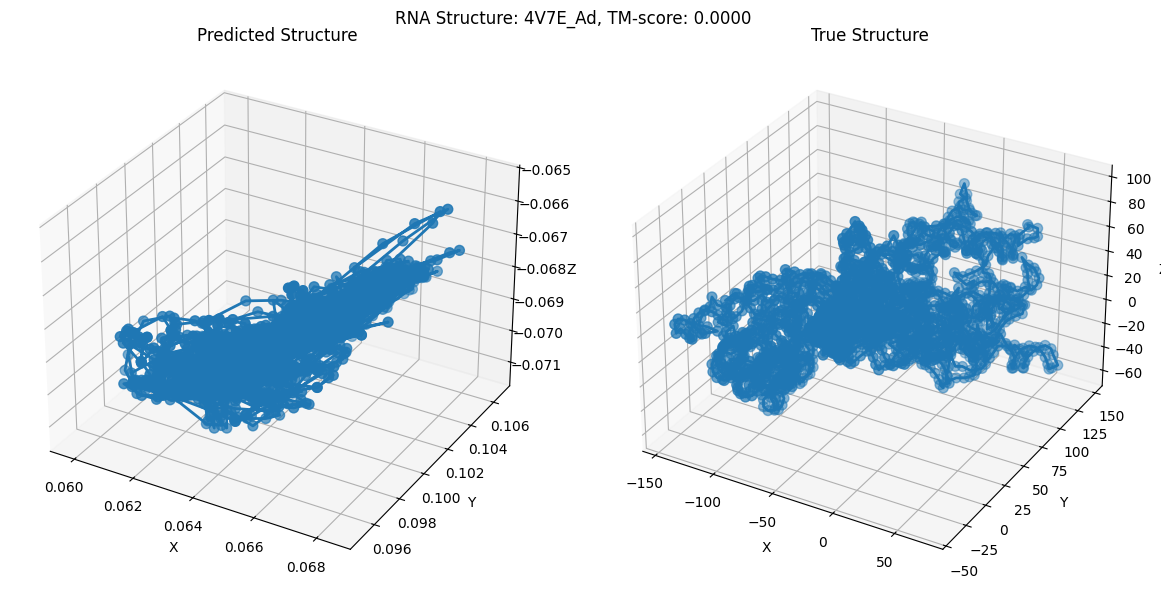

In [ ]:
def evaluate_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    test_loss = 0
    all_tm_scores = []

    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            loss = F.mse_loss(out, data.y)
            test_loss += loss.item() * data.num_graphs

            # Calculate TM-score
            pred_coords = out.detach().cpu().numpy()
            true_coords = data.y.detach().cpu().numpy()

            tm_score = calculate_tm_score(pred_coords, true_coords)
            all_tm_scores.append(tm_score)

    test_loss /= len(test_loader.dataset)
    avg_tm_score = np.mean(all_tm_scores)

    print(f'Test Loss: {test_loss:.4f}, Test TM-score: {avg_tm_score:.4f}')

    return test_loss, avg_tm_score

def visualize_rna_structure(pred_coords, true_coords, title="RNA Structure Comparison"):
    """
    Visualize predicted vs. true RNA structure in 3D
    """
    fig = plt.figure(figsize=(12, 6))

    # Plot predicted structure
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.plot(pred_coords[:, 0], pred_coords[:, 1], pred_coords[:, 2], '-', lw=2)
    ax1.scatter(pred_coords[:, 0], pred_coords[:, 1], pred_coords[:, 2], s=50)
    ax1.set_title('Predicted Structure')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    # Plot true structure
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.plot(true_coords[:, 0], true_coords[:, 1], true_coords[:, 2], '-', lw=2)
    ax2.scatter(true_coords[:, 0], true_coords[:, 1], true_coords[:, 2], s=50)
    ax2.set_title('True Structure')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig('rna_structure_comparison.png')
    plt.show()

# Load the best model and evaluate
best_model = RNAGNN(input_dim=input_dim)
#best_model.load_state_dict(torch.load('best_rna_gnn_model_tm.pth'))
test_loss, test_tm_score = evaluate_model(best_model, test_loader)

# Visualize a sample prediction
sample_data = test_graphs[0]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model.eval()
with torch.no_grad():
    sample_data = sample_data.to(device)
    pred = best_model(sample_data)

    # Get predicted and true coordinates
    pred_coords = pred.cpu().numpy()
    true_coords = sample_data.y.cpu().numpy()

    # Visualize
    visualize_rna_structure(
        pred_coords,
        true_coords,
        title=f"RNA Structure: {sample_data.name}, TM-score: {calculate_tm_score(pred_coords, true_coords):.4f}"
    )


Loading and preprocessing data...
Creating graph representations...
Created 844 RNA structure graphs
Splitting data...
Training model...


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Train Loss: 24542.9156, Val Loss: 26561.9833, Val TM-score: 0.0000, Best TM-score: 0.0000
Epoch: 1, Train Loss: 21355.2972, Val Loss: 26533.8132, Val TM-score: 0.0000, Best TM-score: 0.0000
Epoch: 2, Train Loss: 23063.4985, Val Loss: 26356.5120, Val TM-score: 0.0000, Best TM-score: 0.0000
Epoch: 3, Train Loss: 22345.8079, Val Loss: 25771.2054, Val TM-score: 0.0000, Best TM-score: 0.0000
Epoch: 4, Train Loss: 17923.2074, Val Loss: 27956.1009, Val TM-score: 0.0000, Best TM-score: 0.0000
Epoch: 5, Train Loss: 12658.0663, Val Loss: 30494.2145, Val TM-score: 0.0000, Best TM-score: 0.0000
Epoch: 6, Train Loss: 14562.7816, Val Loss: 29842.5854, Val TM-score: 0.0000, Best TM-score: 0.0000
Epoch: 7, Train Loss: 12866.8838, Val Loss: 28150.6597, Val TM-score: 0.0000, Best TM-score: 0.0000
Epoch: 8, Train Loss: 13178.7911, Val Loss: 29305.0347, Val TM-score: 0.0000, Best TM-score: 0.0000
Epoch: 9, Train Loss: 13073.7435, Val Loss: 29577.7996, Val TM-score: 0.0000, Best TM-score: 0.0000


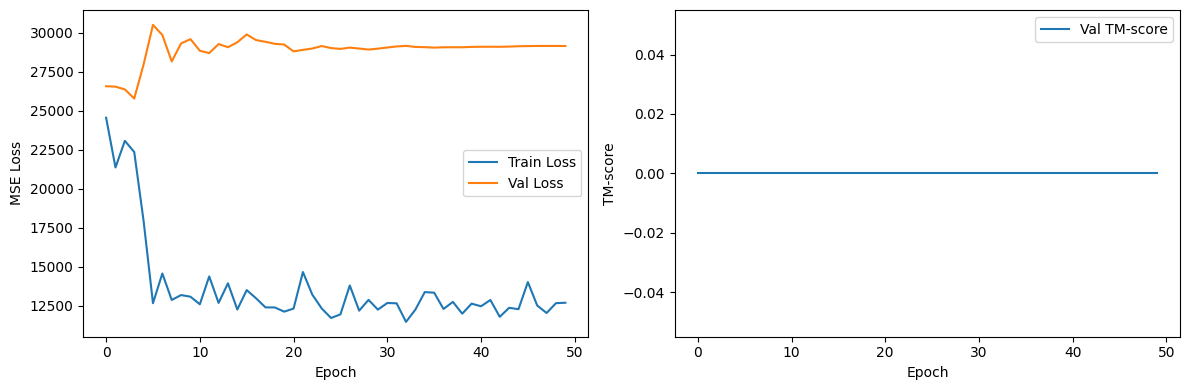

Evaluating model...
Test Loss: 17540.9122, Test TM-score: 0.0000
Final Test TM-Score: 0.0000


In [ ]:
if __name__ == "__main__":
    # Step 1: Load and preprocess data
    print("Loading and preprocessing data...")
    df_sequences = pd.read_csv("/kaggle/cleaned_train_sequences2.csv")
    df_labels = pd.read_csv("/kaggle/train_labels1.csv")

    # Extract 'target_id' from label 'ID' column
    df_labels['target_id'] = df_labels['ID'].apply(lambda x: "_".join(x.split("_")[:2]))

    # Merge on 'target_id'
    df_merged = df_labels.merge(df_sequences, on='target_id', how='left')

    # Step 2: Feature engineering
    print("Creating graph representations...")
    rna_graphs = engineer_rna_features(df_merged)
    print(f"Created {len(rna_graphs)} RNA structure graphs")

    # Step 3: Split data and create dataloaders
    print("Splitting data...")
    train_graphs, test_graphs = train_test_split(rna_graphs, test_size=0.2, random_state=42)
    train_graphs, val_graphs = train_test_split(train_graphs, test_size=0.25, random_state=42)

    train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_graphs, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

    # Step 4: Initialize and train the model
    print("Training model...")
    input_dim = rna_graphs[0].x.shape[1]
    model = RNAGNN(input_dim=input_dim)
    train_losses, val_losses, val_tm_scores = train_model(model, train_loader, val_loader, num_epochs=50)

    # Step 5: Evaluate the model
    print("Evaluating model...")
    best_model = RNAGNN(input_dim=input_dim)
  # best_model.load_state_dict(torch.load('best_rna_gnn_model_tm.pth'))
    test_loss, test_tm_score = evaluate_model(best_model, test_loader)

    print(f"Final Test TM-Score: {test_tm_score:.4f}")


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
import numpy as np
from scipy.spatial.distance import pdist, squareform

class RNAGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=3, heads=4):
        super(RNAGNN, self).__init__()

        # Graph attention layers
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads)
        self.conv2 = GATConv(hidden_dim*heads, hidden_dim, heads=heads)
        self.conv3 = GATConv(hidden_dim*heads, hidden_dim)

        # Coordinate prediction MLP
        self.lin1 = nn.Linear(hidden_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, output_dim)

        # Dropout and batch norm
        self.dropout = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm1d(hidden_dim*heads)
        self.bn2 = nn.BatchNorm1d(hidden_dim*heads)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        # Graph convolutions
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = self.dropout(x)

        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = self.dropout(x)

        x = F.relu(self.conv3(x, edge_index))

        # Coordinate prediction
        x = F.relu(self.lin1(x))
        x = self.lin2(x)

        return x

def engineer_rna_features(df):
    graphs = []
    for target_id, group in df.groupby('target_id'):
        group = group.sort_values(by='resid')
        coords = group[['x_1', 'y_1', 'z_1']].values

        # One-hot encode nucleotide type
        nucleotide_types = {'A': 0, 'C': 1, 'G': 2, 'U': 3}
        one_hot = np.zeros((len(group), 4))
        for i, nt in enumerate(group['resname']):
            if nt in nucleotide_types:
                one_hot[i, nucleotide_types[nt]] = 1

        # Positional encoding
        seq_len = len(group)
        pos_encoding = np.arange(seq_len)[:, None] / seq_len

        # Combine features
        node_features = np.hstack([one_hot, pos_encoding])

        # Distance matrix for edges
        dist_matrix = squareform(pdist(coords))

        # Create edges within 15Å threshold
        threshold = 15.0
        edges = []
        edge_attr = []
        for i in range(seq_len):
            for j in range(i+1, seq_len):
                if dist_matrix[i, j] < threshold:
                    edges.append([i, j])
                    edges.append([j, i])
                    edge_attr.append([dist_matrix[i, j], abs(i-j)])
                    edge_attr.append([dist_matrix[i, j], abs(i-j)])

        edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous() if edges else torch.zeros((2, 0), dtype=torch.long)
        edge_attr = torch.tensor(edge_attr, dtype=torch.float) if edges else torch.zeros((0, 2), dtype=torch.float)

        # Create graph
        x = torch.tensor(node_features, dtype=torch.float)
        y = torch.tensor(coords, dtype=torch.float)
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y, name=target_id)
        graphs.append(data)

    return graphs

def train_model(model, train_loader, val_loader, epochs=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10)
    criterion = nn.MSELoss()

    best_val_loss = float('inf')
    patience = 20
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item() * data.num_graphs

        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                out = model(data)
                val_loss += criterion(out, data.y).item() * data.num_graphs

        val_loss /= len(val_loader.dataset)
        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    model.load_state_dict(torch.load('best_model.pth'))
    return model

# Main execution
if __name__ == "__main__":
    # Load and prepare data
    df_sequences = pd.read_csv("/kaggle/cleaned_train_sequences2.csv")
    df_labels = pd.read_csv("/kaggle/train_labels1.csv")
    df_labels['target_id'] = df_labels['ID'].apply(lambda x: "_".join(x.split("_")[:2]))
    df_merged = df_labels.merge(df_sequences, on='target_id', how='left')

    # Feature engineering
    rna_graphs = engineer_rna_features(df_merged)

    # Train/validation/test split
    train_graphs, test_graphs = train_test_split(rna_graphs, test_size=0.2, random_state=42)
    train_graphs, val_graphs = train_test_split(train_graphs, test_size=0.25, random_state=42)

    # Create dataloaders
    train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_graphs, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_graphs, batch_size=32, shuffle=False)

    # Initialize and train model
    input_dim = rna_graphs[0].x.shape[1]
    model = RNAGNN(input_dim=input_dim)
    model = train_model(model, train_loader, val_loader)

    # Evaluate on test set
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            test_loss += F.mse_loss(out, data.y).item() * data.num_graphs

    print(f'Test Loss: {test_loss/len(test_loader.dataset):.4f}')

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 0, Train Loss: 20953.4079, Val Loss: 26423.6164
Epoch: 1, Train Loss: 16662.6046, Val Loss: 25497.5570
Epoch: 2, Train Loss: 16086.3065, Val Loss: 25525.9132
Epoch: 3, Train Loss: 12198.9198, Val Loss: 25744.6242
Epoch: 4, Train Loss: 12835.6086, Val Loss: 26456.3456
Epoch: 5, Train Loss: 12159.1396, Val Loss: 28111.0224
Epoch: 6, Train Loss: 11750.5364, Val Loss: 30544.9361
Epoch: 7, Train Loss: 10808.6326, Val Loss: 28296.1355
Epoch: 8, Train Loss: 12741.8848, Val Loss: 31577.8798
Epoch: 9, Train Loss: 11670.5169, Val Loss: 30489.8103
Epoch: 10, Train Loss: 12854.8332, Val Loss: 30801.8216
Epoch: 11, Train Loss: 13048.4266, Val Loss: 26498.1016
Epoch: 12, Train Loss: 13169.4444, Val Loss: 28803.4893
Epoch: 13, Train Loss: 11533.7089, Val Loss: 29105.9885
Epoch: 14, Train Loss: 12982.9702, Val Loss: 29059.2270
Epoch: 15, Train Loss: 11761.7416, Val Loss: 28780.5144
Epoch: 16, Train Loss: 11356.1580, Val Loss: 28459.2886
Epoch: 17, Train Loss: 13378.6286, Val Loss: 28990.3361
Ep